# HiClass baseline - descriptions

In [18]:
import os
os.chdir("/home/app/src")

In [37]:
import pandas as pd
import numpy as np
import text_normalizer
import hiclass.metrics
from sklearn import metrics
from scripts.build_df import build_df
from scripts.decode_id import decode_id
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from os import cpu_count
from hiclass import LocalClassifierPerParentNode
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import pickle

In [20]:
no_threshold_df = build_df(json_path='data/products.json', threshold=0) 

In [21]:
# Auxiliary function for text normalization
def normalization(input):
    output = text_normalizer.normalize_corpus(
        input,
        html_stripping=True,
        contraction_expansion=True,
        accented_char_removal=True,
        text_lower_case=True,
        text_stemming=True,
        text_lemmatization=False,
        special_char_removal=True,
        remove_digits=False,
        stopword_removal=True,
        stopwords=text_normalizer.stopword_list
    )       
    return output

# Auxiliary function for creating new columns
def assign_precision(x):
    return hiclass.metrics.precision(x[0:1], x[1:2])
def assign_recall(x):
    return hiclass.metrics.recall(x[0:1], x[1:2])
def assign_f1(x):
    # Condition to avoid ZeroDivisionError
    if x["precision"] * x["recall"] == 0.0:
        return 0.0
    else:
        return 2 * x["precision"] * x["recall"] / (x["precision"] + x["recall"])

In [22]:
X = no_threshold_df['description'].copy()
X = normalization(X.apply(str))
y = no_threshold_df['path'].copy()

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20, 
    random_state=42,
)

In [24]:
tfid_vectorizer = TfidfVectorizer(ngram_range=(1, 2)) 
X_train = tfid_vectorizer.fit_transform(X_train)
X_test = tfid_vectorizer.transform(X_test)

### Hierarchical classification

In [25]:
# Initialize model
random_forest = RandomForestClassifier(random_state=42)
# Initialize hierarchical classifier with model
hierarchical_classifier = hiclass.LocalClassifierPerParentNode(n_jobs=cpu_count(), local_classifier=random_forest)
# Train hierarchical classifier
hierarchical_classifier.fit(X_train, y_train)

# Predict on train and test
y_pred_train = hierarchical_classifier.predict(X_train)
y_pred_test = hierarchical_classifier.predict(X_test)

# Results DataFrame
test_df = pd.DataFrame(y_test)
test_df["prediction"] = pd.Series(y_pred_test.tolist(), index = test_df.index) 
test_df["precision"] = test_df.apply(lambda x: assign_precision(x), axis=1)
test_df["recall"] = test_df.apply(lambda x: assign_recall(x), axis=1)
test_df["f1"] = test_df.apply(lambda x: assign_f1(x), axis=1)

In [26]:
# Print standard results
print("Train")
print("Precision:", hiclass.metrics.precision(y_train, y_pred_train))
print("Recall:", hiclass.metrics.recall(y_train, y_pred_train))
print("F1:", hiclass.metrics.f1(y_train, y_pred_train))
print("\nTest")
print("Precision:", hiclass.metrics.precision(y_test, y_pred_test))
print("Recall:", hiclass.metrics.recall(y_test, y_pred_test))
print("F1:", hiclass.metrics.f1(y_test, y_pred_test))
print("Total failures:", len(test_df["f1"][test_df["f1"] == 0.0]), "of", len(test_df))

Train
Precision: 0.9250788953343722
Recall: 0.9841673400016717
F1: 0.9537087661745943

Test
Precision: 0.7758874402994708
Recall: 0.8318985800094112
F1: 0.8029173679570408
Total failures: 843 of 10330


<AxesSubplot:xlabel='f1', ylabel='Percent'>

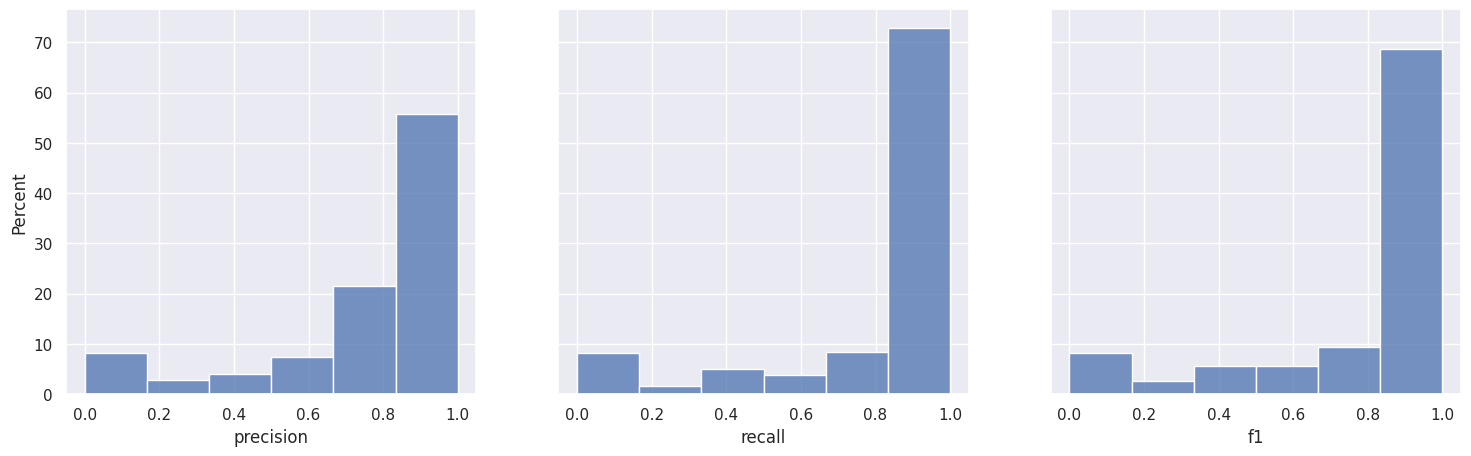

In [27]:
sns.set()
fig, axes = plt.subplots(1,3, figsize=(18,5), sharey=True)
sns.histplot(test_df["precision"], stat="percent", ax=axes[0], bins=6)
sns.histplot(test_df["recall"], stat="percent",ax=axes[1], bins=6)
sns.histplot(test_df["f1"], stat="percent",ax=axes[2], bins=6)

In [28]:
test_df["f1"][test_df["f1"] == 0.0]

34176    0.0
13167    0.0
35627    0.0
31929    0.0
49777    0.0
        ... 
28953    0.0
31535    0.0
24334    0.0
5561     0.0
7023     0.0
Name: f1, Length: 843, dtype: float64

In [35]:
def print_path_metrics(index, df_):
    print("Product name:", no_threshold_df["name"].loc[index])
    print("Product description:\n", no_threshold_df["description"].loc[index], "\n")
    print("Original path:", decode_id(no_threshold_df["path"].loc[index]))
    print("Threshold path:", decode_id(df_["path"].loc[index]))
    print("Predicted path:", decode_id(df_["prediction"].loc[index]))
    print("\nMetrics (on threshold and predicted path)")
    print("Precision:", df_["precision"].loc[index])
    print("Recall:", df_["recall"].loc[index])
    print("F1:", df_["f1"].loc[index])

In [36]:
print_path_metrics(34176, test_df)

Product name: Trademark - Trademark Tools 130-Piece Hand Tool Set
Product description:
 Durable metal construction; two 8-piece Allen wrench sets; two 10-piece driver sets; ratcheting screwdriver; mini screwdrivers; cutters; pliers; hammer; wrench; tape measure; razor; wire stripper 

Original path: ['Connected Home & Housewares', 'Household Essentials', 'Tools', 'Hand Tools']
Threshold path: ['Connected Home & Housewares', 'Household Essentials', 'Tools', 'Hand Tools']
Predicted path: ['Appliances', 'Small Kitchen Appliances', 'Kitchen Gadgets', 'Food Preparation Utensils', '', '', '']

Metrics (on threshold and predicted path)
Precision: 0.0
Recall: 0.0
F1: 0.0


In [38]:
filename = "notebooks/hierarchical_classification/saved_models/descriptions_baseline.sav"
pickle.dump(hierarchical_classifier, open(filename, "wb"))